In [110]:
from itertools import chain
import pandas as pd
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
def read_data():
    
    data = pd.read_csv("dataframe.csv")
    data["dependencies"].fillna("", inplace=True)
    data["relevant_dependencies"].fillna("", inplace=True)
    data["dependencies"] = data["dependencies"].apply(lambda x: x.split("),"))
    data["relevant_dependencies"] = data["relevant_dependencies"].apply(lambda x: x.split("),"))
    data.drop('recommended_exclusion', axis=1, inplace=True)
    data.drop('sentence_id', axis=1, inplace=True)
    
    return data

#fixes some bad rows and seperates data into train and test - note the seperation is not random, it should be.
#dependency collumns are split into rough lists for future
data = read_data()

def process_data(data):
    dataset = []
    feature_set = []
    for i, (position, word, gerund, tags, dependencies, relDependencies, sentence) in data.iterrows():
        feature_set.append(gerund)
        feature_set.append(word)    
        deps = []
        for dependency in relDependencies:
            if len(dependency.split())<3:
                continue
            id = dependency.split()[0]
            w1 = dependency.split()[1][1:-1].split("-")[0]
            p1 = dependency.split()[1][1:-1].split("-")[1]
            w2 = dependency.split()[2].split("-")[0]
            p2 = dependency.split()[2].split("-")[1]
            organized_dependency = (id, w1, p1, w2, p2)
            deps.append(organized_dependency)
        feature_set.append(deps)
        feature_set.append(sentence)
        dataset.append(feature_set)
        feature_set = []
    return dataset

p_data = pd.DataFrame(process_data(data))

In [111]:
p_data.columns = ['type', 'gerund', 'rel_deps', 'sentence']

In [112]:
def count(dep, x):
    sum = 0
    for t in x:
        if t[0] == dep:
            sum += 1
    return sum

def countGerund(dep, x):
    sum = 0
    for t in x:
        if t[0] == dep and (t[1].endswith('ing') or t[3].endswith('ing')):
            sum += 1
    return sum

def countCC(x):
    return count('cc', x)
def countConj(x):
    return count('conj', x)
def countPunct(x):
    return count('punct', x)

def countGerundCC(x):
    return countGerund('cc', x)
def countGerundConj(x):
    return countGerund('conj', x)
def countGerundPunct(x):
    return countGerund('punct', x)


In [113]:
p_data['num_cc'] = p_data['rel_deps'].apply(countCC)
p_data['num_conj'] = p_data['rel_deps'].apply(countConj)
p_data['num_punct'] = p_data['rel_deps'].apply(countPunct)
p_data['num_gerund_cc'] = p_data['rel_deps'].apply(countGerundCC)
p_data['num_gerund_conj'] = p_data['rel_deps'].apply(countGerundConj)
p_data['num_gerund_punct'] = p_data['rel_deps'].apply(countGerundPunct)

In [114]:
p_data

,type,gerund,rel_deps,sentence,num_cc,num_conj,num_punct,num_gerund_cc,num_gerund_conj,num_gerund_punct
0,vp-ing,hearing,"[(xcomp, hearing, 5, remember, 4), (obj, phras...","I do n't remember hearing the phrase "" white g...",0,0,0,0,0,0
1,vp-ing,Growing,"[(advcl, Growing, 1, had, 10), (compound:prt, ...","Growing up black in the 1950s , I never had th...",0,0,0,0,0,0
2,vp-ing,having,"[(conj, irritability, 17, see, 3), (mark, at, ...","I can see now that possibly she was , but then...",0,1,0,0,0,0
3,vp-ing,feeling,"[(xcomp, feeling, 4, remember, 3), (obj, sympa...",I can remember feeling a certain sympathy for ...,0,0,0,0,0,0
4,vp-ing,drawing,"[(advcl, victimizing, 16, feeling, 4), (mark, ...",I can remember feeling a certain sympathy for ...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
55054,vp-ing,restraining,"[(mark, for, 5, restraining, 6), (acl, restrai...",The main government tools for restraining both...,0,0,0,0,0,0
55055,vp-ing,restraining,"[(mark, In, 1, restraining, 2), (advcl, restra...","In restraining such growth , allocation by pri...",0,0,0,0,0,0
55056,vp-ing,learning,"[(obl, negotiations, 8, allow, 5), (punct, ,, ...","Therefore , change must allow for complex nego...",0,1,1,0,1,1
55057,vp-ing,creating,"[(mark, of, 7, creating, 8), (advcl, creating,...","Political wisdom , therefore , consists of cre...",0,0,0,0,0,0


In [115]:
p_data['type'].value_counts(normalize=True)

vp-ing         0.756643
acc-ing        0.108139
ing-of         0.054160
det-ing        0.053742
poss-ing       0.022685
poss-ing-of    0.004631
Name: type, dtype: float64

In [116]:
p_data[p_data['num_cc'] > 0]['type'].value_counts(normalize=True)

vp-ing         0.865684
ing-of         0.057593
acc-ing        0.038661
det-ing        0.023715
poss-ing       0.010562
poss-ing-of    0.003786
Name: type, dtype: float64

In [117]:
p_data[p_data['num_conj'] > 0]['type'].value_counts(normalize=True)

vp-ing         0.804588
acc-ing        0.078047
ing-of         0.049941
det-ing        0.042564
poss-ing       0.020729
poss-ing-of    0.004131
Name: type, dtype: float64

In [118]:
p_data[p_data['num_punct'] > 0]['type'].value_counts(normalize=True)

vp-ing         0.855252
ing-of         0.049371
acc-ing        0.047309
det-ing        0.035916
poss-ing       0.009983
poss-ing-of    0.002170
Name: type, dtype: float64

In [119]:
p_data[p_data['num_gerund_cc'] > 0]['type'].value_counts(normalize=True)

vp-ing         0.880748
ing-of         0.051998
acc-ing        0.034809
det-ing        0.019768
poss-ing       0.008595
poss-ing-of    0.004083
Name: type, dtype: float64

In [120]:
p_data[p_data['num_gerund_conj'] > 0]['type'].value_counts(normalize=True)

vp-ing         0.833333
acc-ing        0.066607
ing-of         0.048277
det-ing        0.033754
poss-ing       0.014123
poss-ing-of    0.003906
Name: type, dtype: float64

In [121]:
p_data[p_data['num_gerund_punct'] > 0]['type'].value_counts(normalize=True)

vp-ing         0.867680
ing-of         0.045506
acc-ing        0.043804
det-ing        0.033023
poss-ing       0.007717
poss-ing-of    0.002270
Name: type, dtype: float64

<AxesSubplot:>

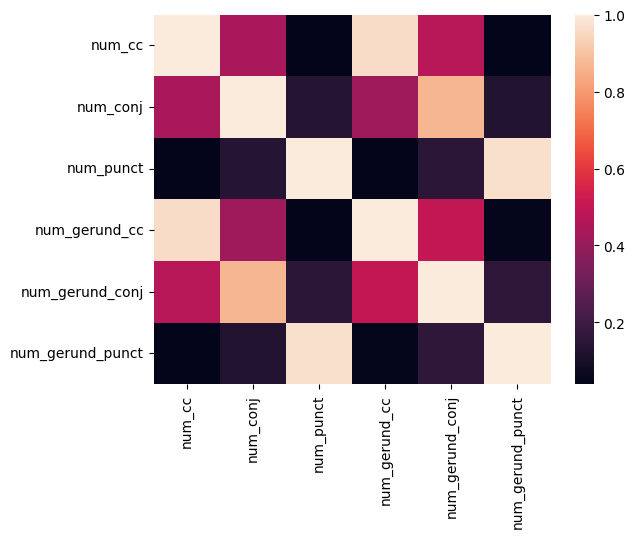

In [122]:
sns.heatmap(p_data.corr())

In [123]:
p_data[(p_data['num_gerund_cc'] > 0) & (p_data['num_gerund_conj'] > 0) & (p_data['num_gerund_punct'] > 0)]['sentence'].iloc[0]

'It is obvious that this was a rather shameful encounter for all concerned -- my friend and I , as his silent accomplice , trading on our racial pain , tampering with a stranger for no reason , and the stranger then buying his way out of the situation for twenty dollars , a sum that was generous by one count and cheap by another .'

In [124]:
from xml.dom.minidom import parse, Node

def set_id_attribute(parent, attribute_name="id"):
    if parent.nodeType == Node.ELEMENT_NODE:
        if parent.hasAttribute(attribute_name):
            parent.setIdAttribute(attribute_name)
    for child in parent.childNodes:
        set_id_attribute(child, attribute_name)

def remove_whitespace(node):
    if node.nodeType == Node.TEXT_NODE:
        if node.nodeValue.strip() == "":
            node.nodeValue = ""
    for child in node.childNodes:
        remove_whitespace(child)

document = parse("en_dimlex.xml")
set_id_attribute(document)
remove_whitespace(document)
document.normalize()

conns = []
for id in range(1,143):
    e = document.getElementById(str(id))
    word = e.getAttribute('word')
    syns = []
    for syn in e.getElementsByTagName("syn"):
        cat = syn.firstChild.firstChild.nodeValue
        cur_syn = {}
        cur_syn['cat'] = cat
        sems = []
        for sem in syn.getElementsByTagName("sem"):
            sense = sem.firstChild.getAttribute('sense')
            pdtb_freq = sem.firstChild.getAttribute('pdtb_freq')
            s = {'sense': sense, 'pdtb_freq': pdtb_freq}
            sems.append(s)
        cur_syn['sems'] = sems
        syns.append(cur_syn)
    modifiers = []
    for pdtb_m in e.getElementsByTagName("pdtb_modifiers"):
        for mod in pdtb_m.getElementsByTagName("modifier"):
            modifier = mod.firstChild.nodeValue
            modifiers.append(modifier)
    conns.append({'word': word, 'syns': syns, 'modifiers': modifiers})

connectives = pd.DataFrame(conns)

In [125]:
# connectives = {'additive': ['moreover', 'further', 'also', 'furthermore'],
# 'causal': ['because', 'hence', 'therefore', 'since'],
# 'temporal': [ 'before', 'next', 'finally', 'after'],
# 'adversative': ['however', 'although', 'in contrast', 'alternatively']}

# for index, row in p_data.iterrows():
#     for type in connectives.keys():
#         for word in connectives[type]:
#             p_data.loc[index, word] = findDepWithWord(row, word)

# for index, row in p_data.iterrows():
#     for type in connectives.keys():
#         p_data.loc[index, type] = ''
#         for word in connectives[type]:
#             dep = findDepWithWord(row, word)
#             if dep != '':
#                 p_data.loc[index, type] = dep

In [126]:
def findDepWithWord(row, kwargs):
    word = kwargs[0]
    for t in row['rel_deps']:
        if t[1] == word and t[3] == row['gerund']: #or t[3] == word and t[1] == row['gerund']:
            return t[0]
    return ''

In [127]:
connectives['word'].iloc[:10]

0            once
1        although
2          though
3             but
4         because
5    nevertheless
6          before
7     for example
8           until
9              if
Name: word, dtype: object

In [128]:
for word in connectives['word']:
    p_data[word] = p_data.apply(findDepWithWord, kwargs=[word], axis=1)

In [129]:
p_data[p_data['although'] != '']['although']

1823     mark
6619     mark
12539    mark
29443    mark
29651    mark
30590    mark
37627    mark
38690    mark
42484    mark
42615    mark
Name: although, dtype: object

In [130]:
gerund_types = list(p_data['type'].unique())
disallowed_deps = ['', 'amod', 'advmod']

cols = gerund_types.copy()
cols.insert(0, 'word')
cols.append('total_count')
conn_stats = pd.DataFrame(columns=cols)
for word in connectives['word']:
    rows = p_data[~p_data[word].isin(disallowed_deps)]
    val_counts = rows['type'].value_counts()
    counts = [word]
    for t in cols[1:7]:
        if t in val_counts.index:
            counts.append(val_counts[t])
        else:
            counts.append(0)
    counts.append(np.sum(counts[1:]))
    conn_stats.loc[len(conn_stats.index)] = counts

In [131]:
connectives['syns'].iloc[0]

[{'cat': 'ADVP',
  'sems': [{'sense': 'Temporal.Asynchronous.Succession', 'pdtb_freq': '2'}]},
 {'cat': 'RB',
  'sems': [{'sense': 'Temporal.Synchrony', 'pdtb_freq': '2'},
   {'sense': 'Contingency.Condition.General', 'pdtb_freq': '2'},
   {'sense': 'Temporal.Asynchronous.Succession', 'pdtb_freq': '38'}]},
 {'cat': 'IN',
  'sems': [{'sense': 'Contingency.Condition.Hypothetical', 'pdtb_freq': '1'},
   {'sense': 'Contingency.Condition.General', 'pdtb_freq': '1'},
   {'sense': 'Temporal.Asynchronous.Succession', 'pdtb_freq': '38'}]}]

In [132]:
conn_types = ['Comparison', 'Expansion', 'Contingency', 'Temporal']
for index, row in connectives.iterrows():
    conn_type_freq = {}
    total_count = 0
    for t in conn_types:
        conn_type_freq[t] = 0
    for item in row['syns']:
        for sem in item['sems']:
            if sem['pdtb_freq'].isdigit():
                conn_type_freq[sem['sense'].split('.')[0]] += int(sem['pdtb_freq'])
                total_count += int(sem['pdtb_freq'])
    for t in conn_types:
        if total_count == 0:
            total_count = 1
        connectives.loc[index, t] = conn_type_freq[t] / total_count

In [133]:
connectives['syns'].iloc[0]

[{'cat': 'ADVP',
  'sems': [{'sense': 'Temporal.Asynchronous.Succession', 'pdtb_freq': '2'}]},
 {'cat': 'RB',
  'sems': [{'sense': 'Temporal.Synchrony', 'pdtb_freq': '2'},
   {'sense': 'Contingency.Condition.General', 'pdtb_freq': '2'},
   {'sense': 'Temporal.Asynchronous.Succession', 'pdtb_freq': '38'}]},
 {'cat': 'IN',
  'sems': [{'sense': 'Contingency.Condition.Hypothetical', 'pdtb_freq': '1'},
   {'sense': 'Contingency.Condition.General', 'pdtb_freq': '1'},
   {'sense': 'Temporal.Asynchronous.Succession', 'pdtb_freq': '38'}]}]

In [134]:
connectives

,word,syns,modifiers,Comparison,Expansion,Contingency,Temporal
0,once,"[{'cat': 'ADVP', 'sems': [{'sense': 'Temporal....",[],0.000000,0.000000,0.047619,0.952381
1,although,"[{'cat': 'IN', 'sems': [{'sense': 'Comparison'...",[],0.996951,0.003049,0.000000,0.000000
2,though,"[{'cat': 'phrase', 'sems': [{'sense': 'Compari...",[even],1.000000,0.000000,0.000000,0.000000
3,but,"[{'cat': 'CC', 'sems': [{'sense': 'Comparison'...",[],0.971886,0.027207,0.000302,0.000605
4,because,"[{'cat': 'phrase', 'sems': [{'sense': 'Conting...","[presumably, partly, in large part, just, larg...",0.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...
137,rather than,"[{'cat': 'ADVP', 'sems': [{'sense': 'Expansion...",[],0.000000,0.000000,0.000000,0.000000
138,after that,"[{'cat': 'PP', 'sems': [{'sense': 'Temporal.As...",[],0.000000,0.000000,0.000000,0.000000
139,not only/but,"[{'cat': 'phrase', 'sems': [{'sense': 'Expansi...",[],0.000000,0.000000,0.000000,0.000000
140,whenever,"[{'cat': 'RB', 'sems': [{'sense': 'Temporal.Sy...",[],0.000000,0.000000,0.000000,0.000000


In [135]:
pd.Series(conn_types).value_counts()

Comparison     1
Expansion      1
Contingency    1
Temporal       1
dtype: int64

In [136]:
for index, row in conn_stats.iterrows():
    for t in conn_types:
        conn_stats.loc[index, t] = connectives[connectives['word'] == row['word']][t].iloc[0]

In [137]:
conn_stats

,word,vp-ing,ing-of,poss-ing,acc-ing,det-ing,poss-ing-of,total_count,Comparison,Expansion,Contingency,Temporal
0,once,1,0,0,2,0,0,3,0.000000,0.000000,0.047619,0.952381
1,although,9,0,0,1,0,0,10,0.996951,0.003049,0.000000,0.000000
2,though,6,0,0,0,2,0,8,1.000000,0.000000,0.000000,0.000000
3,but,115,12,1,9,9,1,147,0.971886,0.027207,0.000302,0.000605
4,because,15,4,5,1,4,3,32,0.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
137,rather than,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
138,after that,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
139,not only/but,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
140,whenever,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000


In [215]:
for t in gerund_types:
    new_col = t + '_normalized'
    conn_stats[new_col] = conn_stats[t].div(conn_stats['total_count'], axis=0)

In [216]:
common_words = conn_stats[conn_stats['total_count'] >= 50]

In [256]:
common_words

,word,vp-ing,ing-of,poss-ing,acc-ing,det-ing,poss-ing-of,total_count,Comparison,Expansion,Contingency,Temporal,vp-ing_normalized,ing-of_normalized,poss-ing_normalized,acc-ing_normalized,det-ing_normalized,poss-ing-of_normalized
3,but,115,12,1,9,9,1,147,0.971886,0.027207,0.000302,0.000605,0.782313,0.081633,0.006803,0.061224,0.061224,0.006803
6,before,146,3,4,1,4,0,158,0.000000,0.000000,0.000000,1.000000,0.924051,0.018987,0.025316,0.006329,0.025316,0.000000
11,when,201,0,1,0,0,0,202,0.012133,0.002022,0.184024,0.801820,0.995050,0.000000,0.004950,0.000000,0.000000,0.000000
12,and,3388,215,43,153,76,15,3890,0.007333,0.968333,0.022667,0.001667,0.870951,0.055270,0.011054,0.039332,0.019537,0.003856
15,while,390,0,1,14,0,1,406,0.660691,0.080666,0.000000,0.258643,0.960591,0.000000,0.002463,0.034483,0.000000,0.002463
19,after,148,10,2,3,11,0,174,0.003466,0.000000,0.000000,0.996534,0.850575,0.057471,0.011494,0.017241,0.063218,0.000000
23,or,584,43,3,22,19,2,673,0.010204,0.969388,0.020408,0.000000,0.867756,0.063893,0.004458,0.032689,0.028232,0.002972
26,instead,50,0,0,0,0,0,50,0.026786,0.973214,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
28,as,570,32,6,24,39,2,673,0.006729,0.002692,0.288022,0.702557,0.846954,0.047548,0.008915,0.035661,0.057949,0.002972
35,rather,121,4,1,3,5,0,134,0.235294,0.764706,0.000000,0.000000,0.902985,0.029851,0.007463,0.022388,0.037313,0.000000


In [257]:
common_words_corr = common_words[~common_words['word'].isin(['with', 'without', 'upon'])].corr()
conn_stats_corr = conn_stats.corr()

In [258]:
common_words_corr

,vp-ing,ing-of,poss-ing,acc-ing,det-ing,poss-ing-of,total_count,Comparison,Expansion,Contingency,Temporal,vp-ing_normalized,ing-of_normalized,poss-ing_normalized,acc-ing_normalized,det-ing_normalized,poss-ing-of_normalized
vp-ing,1.000000,0.988345,0.964233,0.996074,0.917783,0.984167,0.999877,-0.264589,0.284278,0.387187,-0.365487,-0.236481,0.286322,0.233587,0.396605,-0.095760,0.354763
ing-of,0.988345,1.000000,0.936559,0.982633,0.906724,0.991408,0.989267,-0.271144,0.353546,0.303788,-0.375823,-0.306563,0.380590,0.222590,0.409925,-0.020968,0.388859
poss-ing,0.964233,0.936559,1.000000,0.976337,0.947228,0.913780,0.966119,-0.295165,0.152814,0.575441,-0.333939,-0.260010,0.275492,0.369051,0.383271,-0.040534,0.298290
acc-ing,0.996074,0.982633,0.976337,1.000000,0.936161,0.974995,0.996880,-0.227592,0.261129,0.435207,-0.402313,-0.281396,0.320370,0.241140,0.446872,-0.055964,0.392602
det-ing,0.917783,0.906724,0.947228,0.936161,1.000000,0.869059,0.922962,-0.322498,0.113533,0.624813,-0.305977,-0.434760,0.437888,0.329374,0.497801,0.169005,0.397119
poss-ing-of,0.984167,0.991408,0.913780,0.974995,0.869059,1.000000,0.983707,-0.198284,0.350043,0.237325,-0.381513,-0.262710,0.327467,0.176534,0.414826,-0.074048,0.413333
total_count,0.999877,0.989267,0.966119,0.996880,0.922962,0.983707,1.000000,-0.265769,0.282521,0.393308,-0.366967,-0.248005,0.297386,0.237834,0.402942,-0.083269,0.359797
Comparison,-0.264589,-0.271144,-0.295165,-0.227592,-0.322498,-0.198284,-0.265769,1.000000,-0.238746,-0.262009,-0.326160,-0.287408,0.187233,-0.306948,0.577481,0.154770,0.615233
Expansion,0.284278,0.353546,0.152814,0.261129,0.113533,0.350043,0.282521,-0.238746,1.000000,-0.345714,-0.632086,0.176519,0.023199,-0.401947,-0.104493,-0.318068,-0.044368
Contingency,0.387187,0.303788,0.575441,0.435207,0.624813,0.237325,0.393308,-0.262009,-0.345714,1.000000,-0.127734,-0.159753,0.071230,0.306980,0.252028,0.063055,0.091791


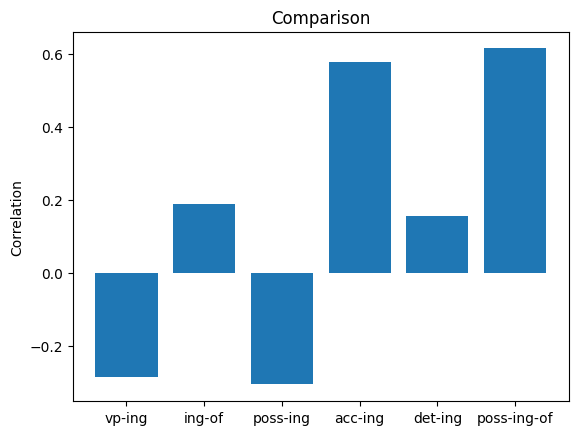

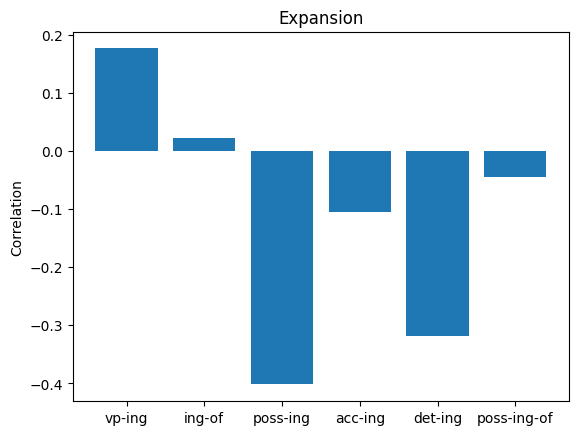

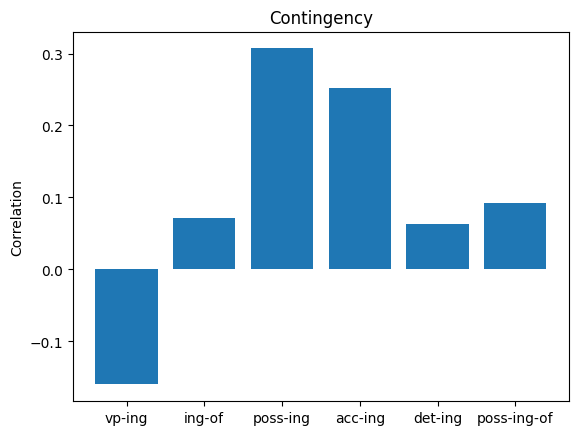

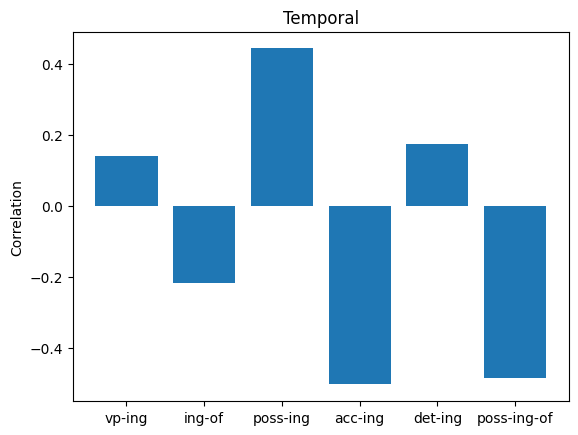

In [262]:
for ct in conn_types:
    names = []
    h = []
    for gt in gerund_types:
        names.append(gt)
        h.append(common_words_corr.loc[ct, gt+'_normalized'])
    plt.figure()
    plt.bar(names, h)
    plt.title(ct)
    plt.ylabel('Correlation')

In [261]:
common_words

,word,vp-ing,ing-of,poss-ing,acc-ing,det-ing,poss-ing-of,total_count,Comparison,Expansion,Contingency,Temporal,vp-ing_normalized,ing-of_normalized,poss-ing_normalized,acc-ing_normalized,det-ing_normalized,poss-ing-of_normalized
3,but,115,12,1,9,9,1,147,0.971886,0.027207,0.000302,0.000605,0.782313,0.081633,0.006803,0.061224,0.061224,0.006803
6,before,146,3,4,1,4,0,158,0.000000,0.000000,0.000000,1.000000,0.924051,0.018987,0.025316,0.006329,0.025316,0.000000
11,when,201,0,1,0,0,0,202,0.012133,0.002022,0.184024,0.801820,0.995050,0.000000,0.004950,0.000000,0.000000,0.000000
12,and,3388,215,43,153,76,15,3890,0.007333,0.968333,0.022667,0.001667,0.870951,0.055270,0.011054,0.039332,0.019537,0.003856
15,while,390,0,1,14,0,1,406,0.660691,0.080666,0.000000,0.258643,0.960591,0.000000,0.002463,0.034483,0.000000,0.002463
19,after,148,10,2,3,11,0,174,0.003466,0.000000,0.000000,0.996534,0.850575,0.057471,0.011494,0.017241,0.063218,0.000000
23,or,584,43,3,22,19,2,673,0.010204,0.969388,0.020408,0.000000,0.867756,0.063893,0.004458,0.032689,0.028232,0.002972
26,instead,50,0,0,0,0,0,50,0.026786,0.973214,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
28,as,570,32,6,24,39,2,673,0.006729,0.002692,0.288022,0.702557,0.846954,0.047548,0.008915,0.035661,0.057949,0.002972
35,rather,121,4,1,3,5,0,134,0.235294,0.764706,0.000000,0.000000,0.902985,0.029851,0.007463,0.022388,0.037313,0.000000


In [221]:
def exampleSentence(conn, gerund_type, dep=None, gerund=None, i=0):
    if dep==None and gerund==None:
        examples = p_data[~(p_data[conn].isin(disallowed_deps)) & (p_data['type'] == gerund_type)]
    elif dep==None:
        examples = p_data[~(p_data[conn].isin(disallowed_deps)) & (p_data['type'] == gerund_type) & (p_data['gerund'].str.lower() == gerund.lower())]
    elif gerund==None:
        examples = p_data[(p_data[conn] == dep) & (p_data['type'] == gerund_type)]
    else:
        examples = p_data[(p_data[conn] == dep) & (p_data['type'] == gerund_type) & (p_data['gerund'].str.lower() == gerund.lower())]
    if i < len(examples):
        return examples.iloc[i]['sentence'], len(examples)
    return '', len(examples)

In [222]:
#Conclusions:
#when - only vp-ing?
#     - only has one poss-ing, doesn't appear to be right

#while - only vp-ing?
#      - 1 poss-ing, 14 acc-ing, don't appear to be right
#Ex: Therefore , it is difficult to maintain the notion , on the one hand , that traditional African law does not apply 
#since the enemy is in some sense ' alien , ' while at the same time contending that international humanitarian law has only 
#limited application since the conflict is an ' internal ' one .

#before - only vp-ing?
#ing-of ex: All of these businesses were to become phenomenally successful even before the opening of the PRC in 1978 .
#det-ing ex: Long before the coming of Martin Luther King , Jr .

#after
#ing-of ex: The idea of having directly elected members in the Legislative Council was first introduced in 1985 after the signing of the Joint Declaration .
#det-ing ex: Ten days later a reminder post card was sent to all persons in the sample , followed by a new letter and a survey to non-responders , mailed 3 
#weeks after the original mailing .

#with and upon - much lower vp-ing

#without - has all forms, but rare other than vp-ing


Word: but, type: vp-ing
It has been , it is my impression , not architects but their critics -- as well as resisting homeowners , tenants , and residents of old areas -- who have limited mass clearance and have sparked as much rehabilitation as we have .
Num results: 115

Word: but, type: ing-of
It sees transcendence not as a movement toward a more inclusive selfhood but rather as the beginning of a transformative interaction between the egoic self and transcendent , non-egoic forces .
Num results: 12

Word: but, type: poss-ing
( What brought him shame was not the pain and anger , but his trading on them for what turned out to be a mere twenty bucks .
Num results: 1

Word: but, type: acc-ing
In either case , the only sufficiently human response to such a threat would be to embrace it , not in the manner of Christ but after Jacob wrestling at Peniel .
Num results: 9

Word: but, type: det-ing
But there had not been enough of these informing signs , and I had grown up contained in a histo

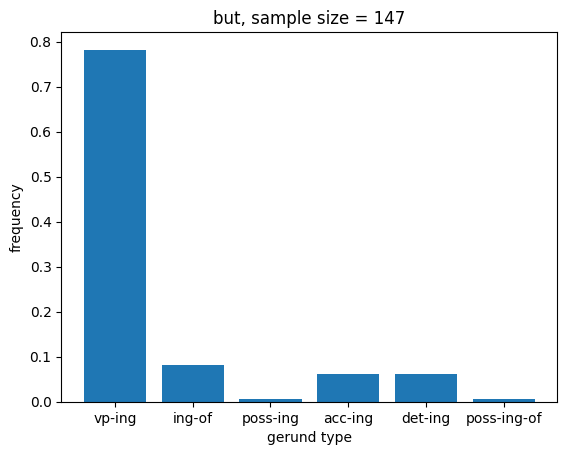

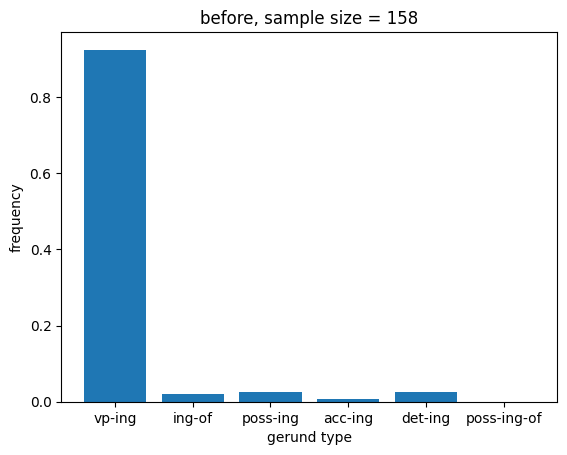

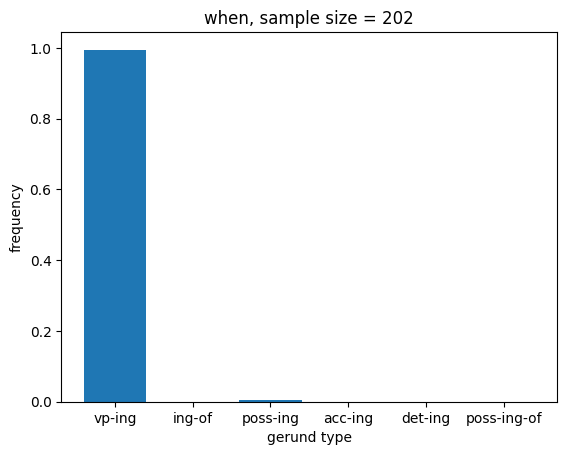

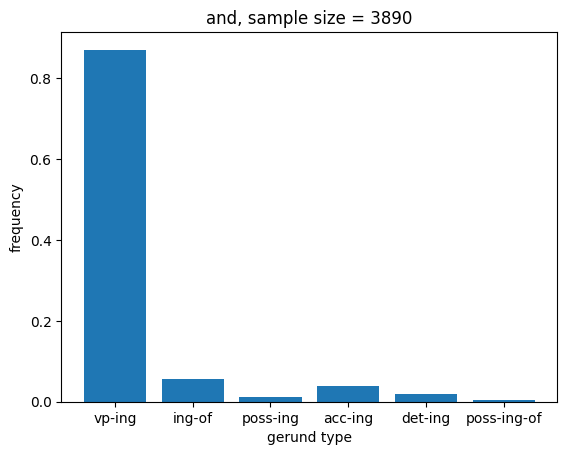

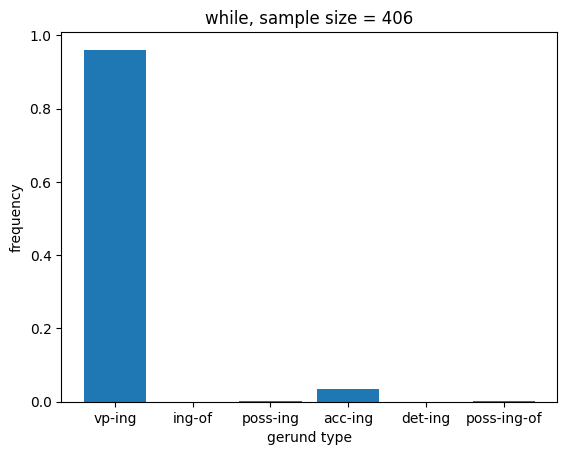

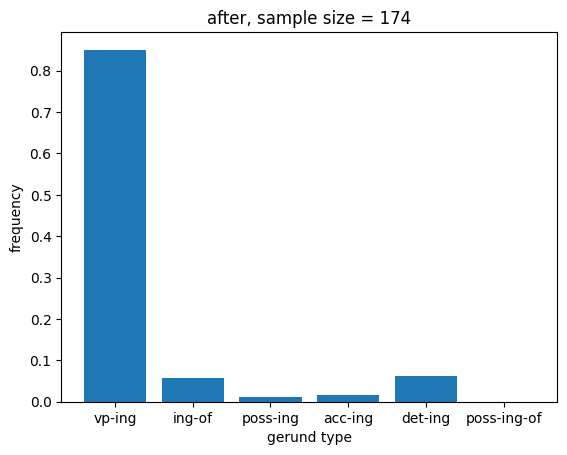

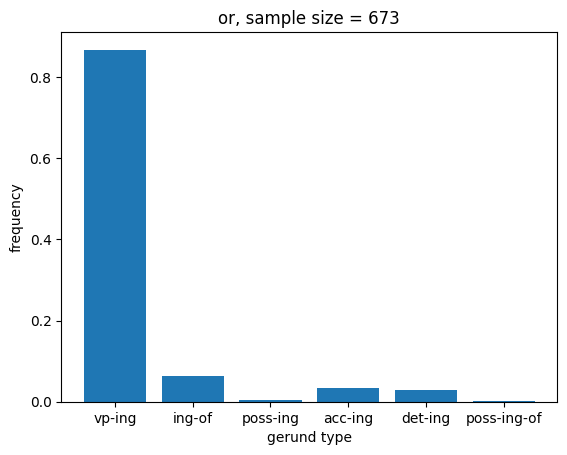

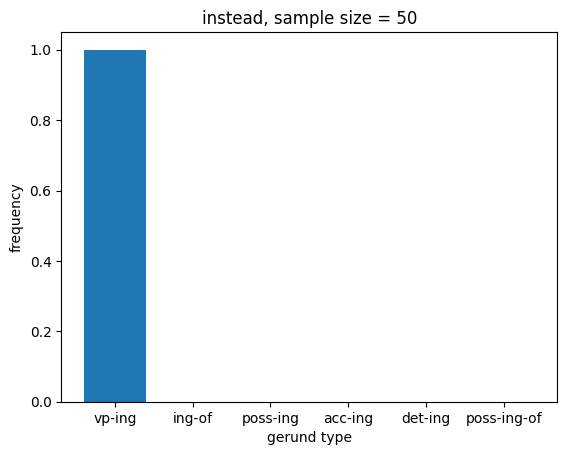

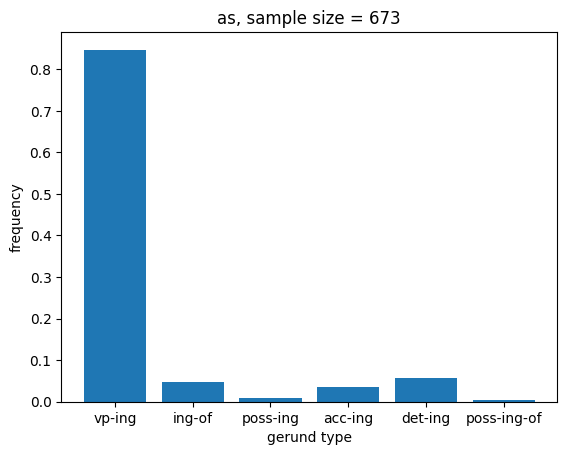

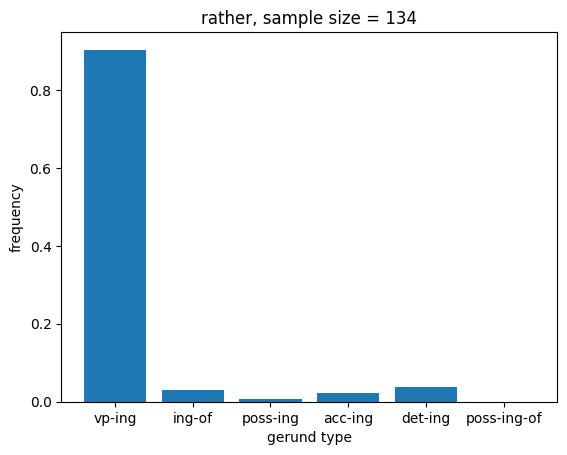

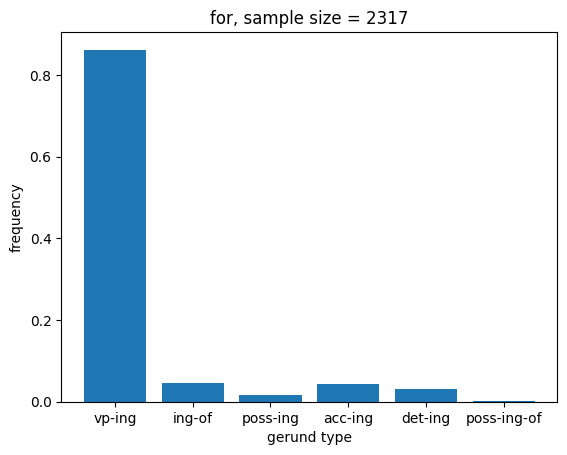

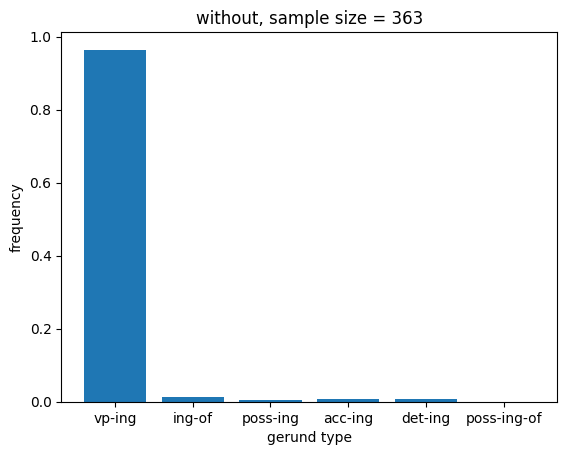

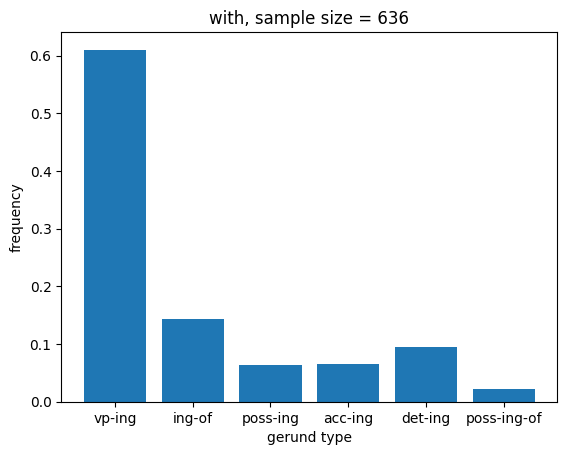

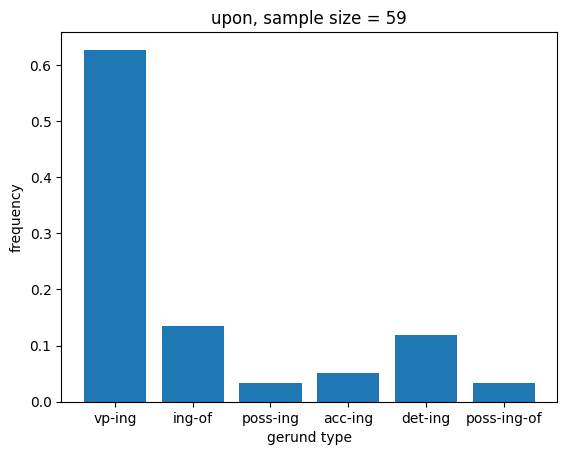

In [229]:
i = 0
for index, row in common_words.iterrows():
    total_count = row['total_count']
    if total_count == 0:
        continue
    word = row['word']
    plt.figure()
    plt.bar(gerund_types, row[[(t + "_normalized") for t in gerund_types]])
    plt.title(word + ", sample size = " + str(total_count))
    plt.xlabel('gerund type')
    plt.ylabel('frequency')
    i += 1
    for t in gerund_types:
        print('Word: ' + word + ", type: " + t)
        sent, size = exampleSentence(word, t,i=0)
        print(sent)
        print("Num results: " + str(size) + '\n')

In [241]:
dep_list = set()
for col in p_data[connectives['word']].columns:
    for val in p_data[connectives['word']][col].unique():
        dep_list.add(val)

In [243]:
dep_list = [
 'acl',
 'advcl',
 'advmod',
 'amod',
 'case',
 'cc',
 'ccomp',
 'conj',
 'fixed',
 'mark',
 'nmod',
 'nsubj',
 'obj',
 'obl']

In [252]:
dep_counts = {}
for d in dep_list:
    dep_counts[d] = {}
    for t in gerund_types:
        dep_counts[d][t] = 0
for index, row in p_data.iterrows():
    for conn in connectives['word']:
        if row[conn] != '':
            dep_counts[row[conn]][row['type']] += 1

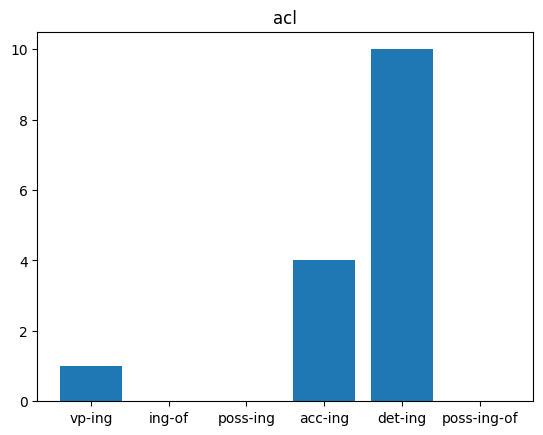

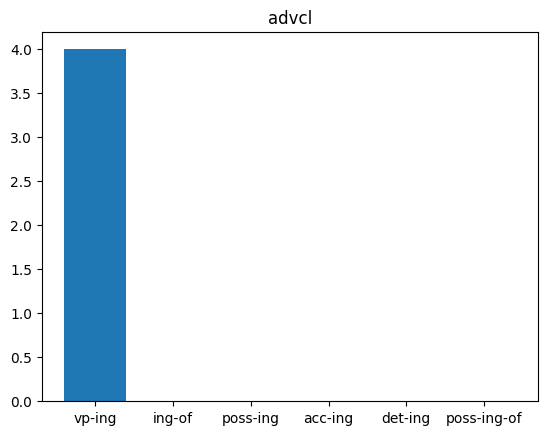

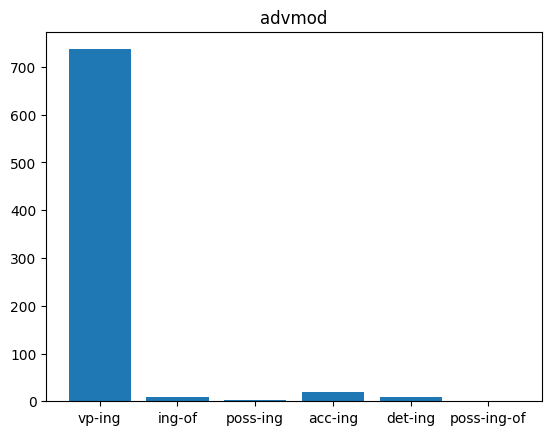

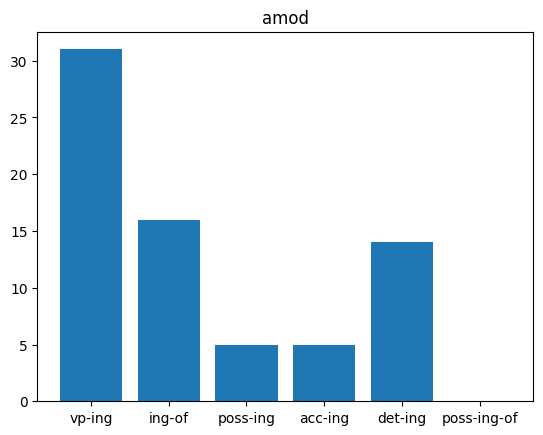

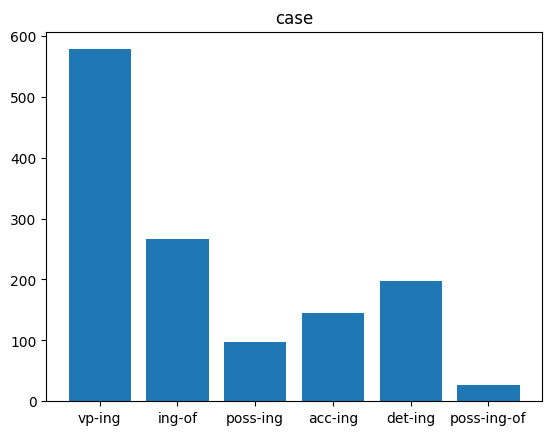

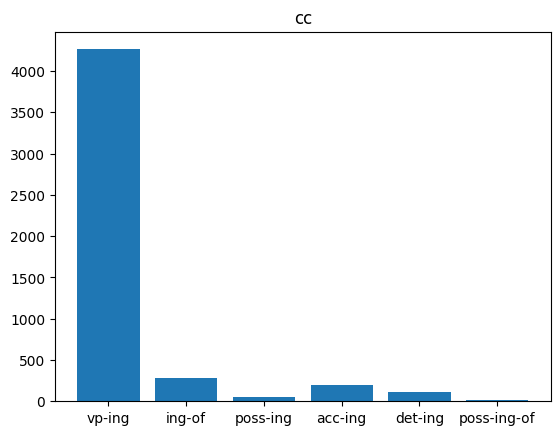

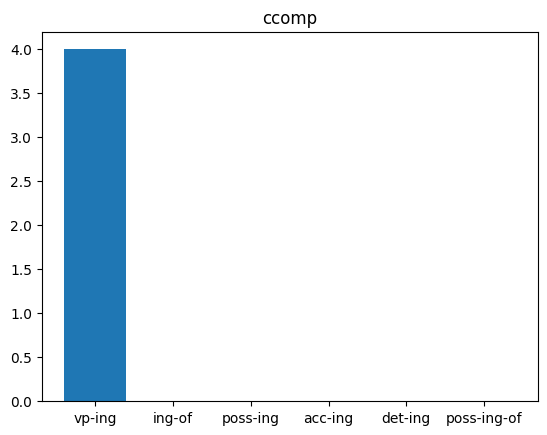

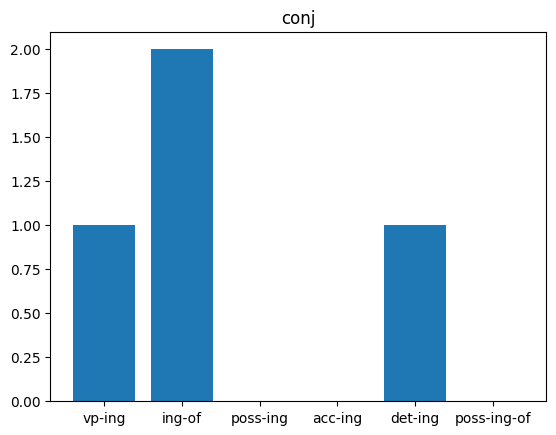

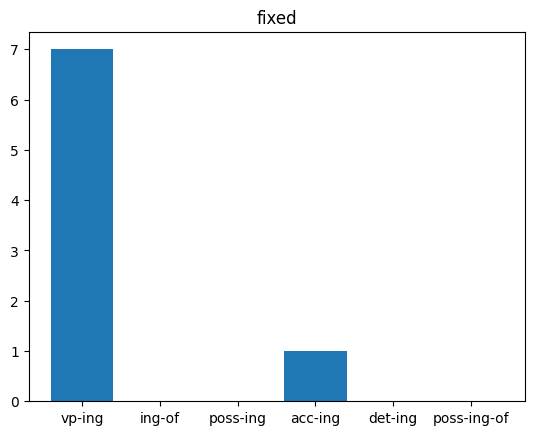

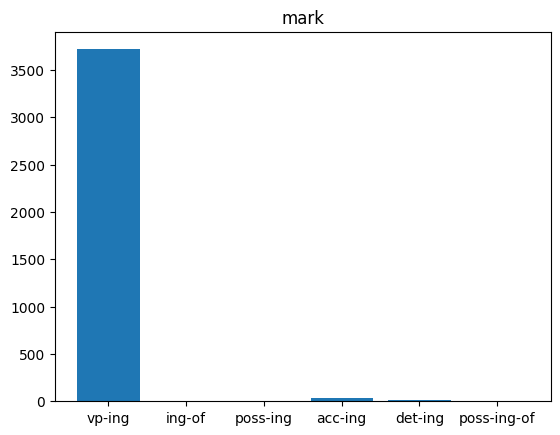

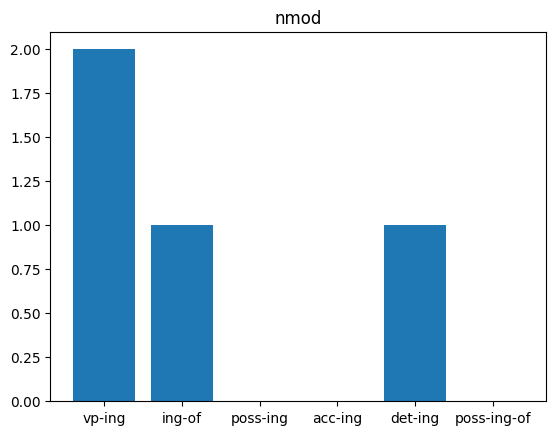

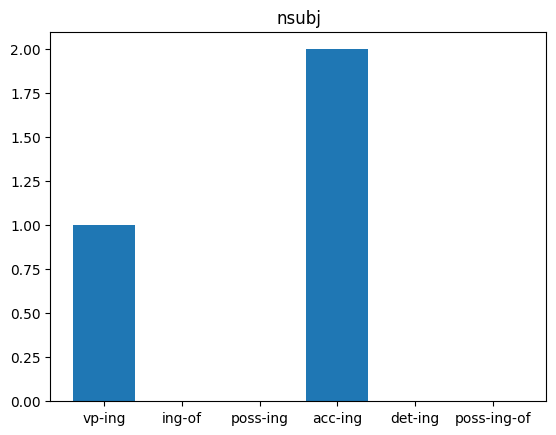

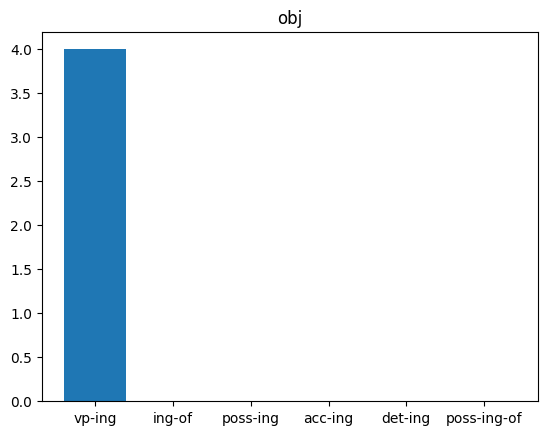

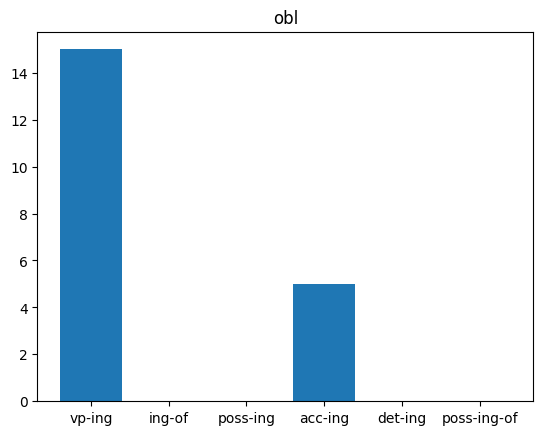

In [255]:
for d in dep_list:
    h = []
    for t in gerund_types:
        h.append(dep_counts[d][t])
    plt.figure()
    plt.bar(gerund_types, h)
    plt.title(d)


In [253]:
dep_counts

{'acl': {'vp-ing': 1,
  'ing-of': 0,
  'poss-ing': 0,
  'acc-ing': 4,
  'det-ing': 10,
  'poss-ing-of': 0},
 'advcl': {'vp-ing': 4,
  'ing-of': 0,
  'poss-ing': 0,
  'acc-ing': 0,
  'det-ing': 0,
  'poss-ing-of': 0},
 'advmod': {'vp-ing': 737,
  'ing-of': 10,
  'poss-ing': 3,
  'acc-ing': 20,
  'det-ing': 8,
  'poss-ing-of': 0},
 'amod': {'vp-ing': 31,
  'ing-of': 16,
  'poss-ing': 5,
  'acc-ing': 5,
  'det-ing': 14,
  'poss-ing-of': 0},
 'case': {'vp-ing': 578,
  'ing-of': 266,
  'poss-ing': 98,
  'acc-ing': 145,
  'det-ing': 198,
  'poss-ing-of': 26},
 'cc': {'vp-ing': 4263,
  'ing-of': 282,
  'poss-ing': 52,
  'acc-ing': 193,
  'det-ing': 114,
  'poss-ing-of': 19},
 'ccomp': {'vp-ing': 4,
  'ing-of': 0,
  'poss-ing': 0,
  'acc-ing': 0,
  'det-ing': 0,
  'poss-ing-of': 0},
 'conj': {'vp-ing': 1,
  'ing-of': 2,
  'poss-ing': 0,
  'acc-ing': 0,
  'det-ing': 1,
  'poss-ing-of': 0},
 'fixed': {'vp-ing': 7,
  'ing-of': 0,
  'poss-ing': 0,
  'acc-ing': 1,
  'det-ing': 0,
  'poss-ing-of': 0

In [224]:
#any common connectives that aren't common with gerunds?
#any patterns with certain 
#group by temporal, etc